In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sp.init_printing()
import ipywidgets as ipw

# Fracture process segment

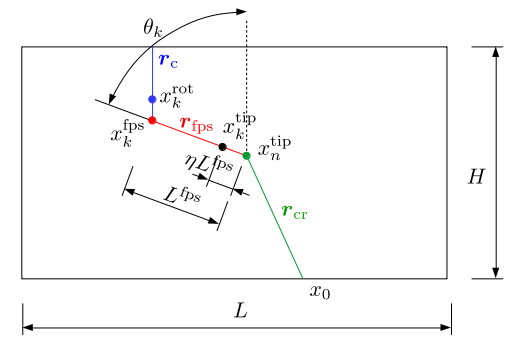

The crack path consists of three segments. The lower segment $x_\mathrm{L}$ represents the localized crack. It can be represented by a continuous curve, i.e. spline or by piecewise linear geometry. The upper segment $x_\mathrm{U}$ represents the uncracked zone. The segments in-between represents the fracture process zone FZP which has a fixed length $L^\mathrm{fps}$ and orientation $\theta$ related to the vertical direction $z$. The coordinates of the segment start $x^{\mathrm{fps}}_{ak}$ is implicitly considered to be in the state of peak tensile stress. The position of the tip of the segment is then given as
\begin{align}
x^{\mathrm{fps}}_{ak} = x^{\mathrm{tip}}_{an} + L^{\mathrm{fps}} 
\left[
\begin{array}{c}
-\sin(\theta) \\ \cos(\theta) 
\end{array}
\right] 
\end{align}

In [2]:
theta = sp.symbols(r'\theta', nonnegative=True)
L_fps = sp.symbols(r'L_\mathrm{fps}', nonnegative=True)
ell = sp.symbols(r'\ell', nonnegative=True)

# Identify the rotation for given crack opening

Kinematics of the section based on the assumption 
that the right side of the shear zone rotates relatively 
to the fixed left side around an unknown position $x^{\mathrm{rot}}_{ak}$. The horizontal position of the center of rotation is assumed identical with the tip of the process zone segment $x^{\mathrm{tip}}_{ak}$, i.e.
\begin{align}
x^{\mathrm{rot}}_{0k} = x^{\mathrm{tip}}_{0k}
\end{align}

The criterion of a crack reaching the strength is defined in strains. This brings about the possibility to circumvent the discussion on the bi-axial stress criterion. This can be seen in analogy to a compression test failure simulated as micro-cracking with cracks oriented in the loading direction.
For this purpose, it is important to include the 

In [3]:
phi, x_rot_1k = sp.symbols(
   r'phi, x^\mathrm{rot}_{1k}', nonegative=True
)
x_tip_0n = sp.symbols(r'x^{\mathrm{tip}}_{0n}')
x_tip_1n = sp.symbols(r'x^{\mathrm{tip}}_{0n}')
xi = sp.symbols('xi')
w = sp.Symbol('w', nonnegative=True)

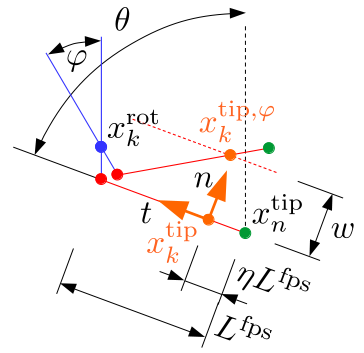

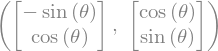

In [4]:
t_vec = sp.Matrix([[-sp.sin(theta), sp.cos(theta)]]).T
n_vec = sp.Matrix([[sp.cos(theta), sp.sin(theta)]]).T
t_vec, n_vec

In [5]:
x_tip_an = sp.Matrix([[x_tip_0n, x_tip_1n]]).T
x_fps_ak = x_tip_an + L_fps * t_vec
x_rot_0k = x_fps_ak[0]
x_rot_0k

 * $t$ is the line vector of the fracture propagation segment
 * $n$ is a vector normal to the fracture propagation segment

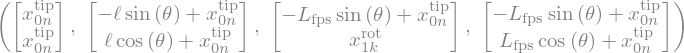

In [6]:
x_tip_ak = x_tip_an + ell * t_vec
x_rot_ak = sp.Matrix([[x_rot_0k, x_rot_1k]]).T 
x_tip_an, x_tip_ak, x_rot_ak, x_fps_ak

The final position must be on a line parallel to $t$ in 
the distance $w$

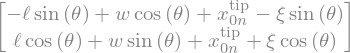

In [7]:
x_phi_xi_ak = x_tip_ak + w * n_vec + xi * t_vec
x_phi_xi_ak

The distance $|RP| = R-P$ must be equal to $|RQ| = R-Q$. Let us express the squares of the distances

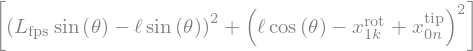

In [8]:
v_tip_ak = (x_tip_ak - x_rot_ak)
len_v_tip_ak_2 = v_tip_ak.T *  v_tip_ak
len_v_tip_ak_2

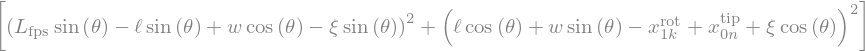

In [9]:
v_phi_xi_ak = (x_phi_xi_ak - x_rot_ak)
len_v_phi_xi_ak_2 = v_phi_xi_ak.T * v_phi_xi_ak
len_v_phi_xi_ak_2

The equal distance can be used to resolve the unknown slip parameter $s$  

In [10]:
eq_slip = sp.simplify(len_v_tip_ak_2[0] - len_v_phi_xi_ak_2[0])

TODO - check if this equation can be prepared for solution in a more efficient way

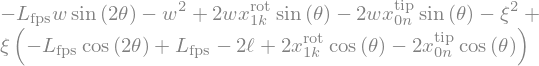

In [11]:
eq_slip_collect = sp.collect(eq_slip,xi)
eq_slip_collect

In [12]:
a, b, c = sp.symbols('a, b, c')
subs_abc = {coeff_var : eq_slip_collect.coeff(xi,i) 
            for coeff_var, i in zip([a,b,c],[0,1,2]) }
slip_sol_quad_0 = sp.solve(a*xi**2 + b*xi +c, xi)[1].subs(subs_abc)

In [13]:
slip_sols = sp.solve(eq_slip_collect, xi)

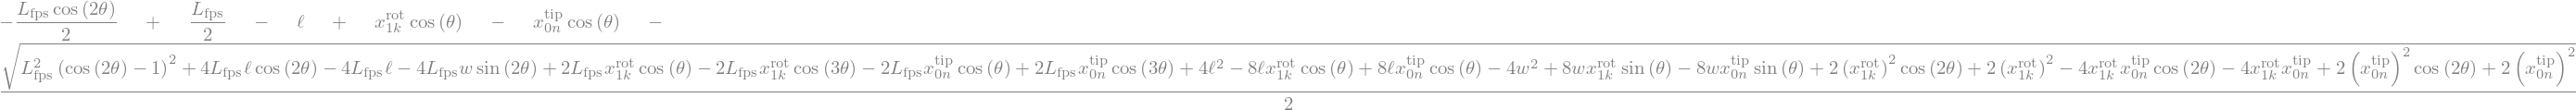

In [14]:
slip_sols[0]

In [15]:
slip_sol_0 = slip_sols[0]

In [16]:
d_slip_theta = slip_sol_0.diff(theta)
d_slip_x_rot_1k = slip_sol_0.diff(x_rot_1k)

In [19]:
py_vars = ('theta', 'x_rot_1k', 'x_tip_0n', 'x_tip_1n', 'L_fps', 'ell', 'w')
map_py2sp = {py_var : globals()[py_var] for py_var in py_vars}
sp_vars = tuple(map_py2sp[py_var] for py_var in py_vars)
sp_vars

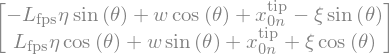

In [20]:
fig, ax = plt.subplots(1,1,figsize=(6,3),tight_layout=True)

import traits.api as tr

class SZModel(tr.HasTraits):

    H = tr.Float(1.0)
    L = tr.Float(4.0)
    B = tr.Float(0.2)
    # define the free parameters as traits with default, min and max values
    theta = tr.Float(0.8, min=0, max=np.pi/2, interact=True)
    x_rot_1k = tr.Float(0.5, min=0, max=1, interact=True)
    x_tip_0n = tr.Float(2, min=0, max=5, interact=True)
    x_tip_1n = tr.Float(0.1, min=0, max=1, interact=True)
    L_fps = tr.Float(0.2, min=0, max=0.5, interact=True)
    ell = tr.Float(0.05, min=0, max=0.1, interact=True)
    w = tr.Float(0.03, min=0, max=0.2, interact=True)
    
    params_ = tr.Tuple(0.8, 1, 0, 0.5, 0.5, 0.1)

    def set_all_points(self, *plot_params):
        self.x_rot_ak_ = get_x_rot_ak(*plot_params)
        self.x_tip_an_ = get_x_tip_an(*plot_params)
        self.x_tip_ak_ = get_x_tip_ak(*plot_params)
        self.x_phi_ak_ = get_x_phi_ak(*plot_params)
        self.x_fps_ak_ = get_x_fps_ak(*plot_params)

    def plot_all_points(self, w):
        ax.axis('equal')
        ax.set_ylim(ymin=0,ymax=self.H)
        ax.set_xlim(xmin=0,xmax=self.L)
        plot_params = (self.params_ + (w,))
        self.set_all_points(*plot_params)
        self.x_rot_ak_p, = ax.plot(*self.x_rot_ak_, marker='o', color='blue')
        self.x_tip_an_p, = ax.plot(*self.x_tip_an_, marker='o', color='green')
        self.x_tip_ak_p, = ax.plot(*self.x_tip_ak_, marker='o', color='orange')
        self.x_phi_ak_p, = ax.plot(*self.x_phi_ak_, marker='o', color='orange')
        self.x_fps_ak_p, = ax.plot(*self.x_fps_ak_, marker='o', color='red')
        self.red_line_p, = ax.plot(*np.c_[self.x_tip_an_, self.x_fps_ak_],
            color='red')
        self.blue_line_p, = ax.plot(*np.c_[self.x_fps_ak_, self.x_rot_ak_],
            color='blue')

    def update_plot(self, **values):
        param_vals = tuple(values[py_var] for py_var in py_vars)
        self.set_all_points(*param_vals)
        self.x_rot_ak_p.set_data(*self.x_rot_ak_)
        self.x_tip_an_p.set_data(*self.x_tip_an_)
        self.x_tip_ak_p.set_data(*self.x_tip_ak_)
        self.x_phi_ak_p.set_data(*self.x_phi_ak_)
        self.x_fps_ak_p.set_data(*self.x_fps_ak_)
        self.red_line_p.set_data(*np.c_[self.x_tip_an_, self.x_fps_ak_])
        self.blue_line_p.set_data(*np.c_[self.x_fps_ak_, self.x_rot_ak_])

        
    n_steps = tr.Int(50)
    def get_ipw_sliders(self):
        traits = self.traits(interact=True)
        vals = self.trait_get(interact=True)
        return { name : ipw.FloatSlider(
            value=vals[name],
            min=trait.min,
            max=trait.max,
            step=trait.max/self.n_steps,
            description=r'\(%s\)' % map_py2sp[name].name)
            for (name, trait) in traits.items()
        }
        
    def interact(self):
        self.plot_all_points(0.1)
        sliders = self.get_ipw_sliders()
        out = ipw.interactive_output(self.update_plot,sliders);
        layout = ipw.Layout(grid_template_columns='1fr 1fr')
        sliders_list = [sliders[py_var] for py_var in py_vars]
        grid = ipw.GridBox(sliders_list, layout=layout)
        box = ipw.VBox([grid, out])
        display(box)


kinem = SZModel()
kinem.interact()


# Rotation angle and rotation matrix 

Given the initial vector $v_{ak}^\mathrm{tip}$ and the rotated
vector $v_{ak}^\mathrm{\varphi}$, the $\cos$ and $\sin$ 
needed for the rotation matrix is expressed as
\begin{align}
| v_{k}^\mathrm{tip} | = \sqrt{v_{ak}^\mathrm{tip} v_{ak}^\mathrm{tip}}
\end{align}
\begin{align}
\cos(\varphi)_k = \frac{v_{ak}^\mathrm{tip} v_{bk}^\varphi} {| v_{k}^\mathrm{tip} |}
&=
\frac{v_{ak}^\mathrm{tip} v_{bk}^\varphi} {\sqrt{v_{ak}^\mathrm{tip} v_{ak}^\mathrm{tip}}}
\end{align}
the derivative with respect to $\theta$ and $x_ak^\mathrm{rot}$
\begin{align}
\cos(\varphi)_{k,\theta\zeta} = \frac{v_{ak}^\mathrm{tip} v_{bk}^\varphi} {| v_{k}^\mathrm{tip} |}
&=
\frac{v_{ak}^\mathrm{tip} v_{bk}^\varphi} {\sqrt{v_{ak}^\mathrm{tip} v_{ak}^\mathrm{tip}}}
\end{align}

In [ ]:
sp.Function('fa_1')(theta, x_rot_1k)

In [ ]:
a_1, a_2, b_1, b_2 = sp.symbols('a_1, a_2, b_1, b_2')
a_mtx = sp.Matrix([a_1, a_2])
b_mtx = sp.Matrix([b_1, b_2])

In [ ]:
a_norm = sp.sqrt(a_mtx.T * a_mtx)

In [ ]:
dot_ab = a_mtx.T * b_mtx

In [ ]:
sp.simplify((dot_ab * a_norm**(-1))**2)

In [ ]:
v_tip_ak_mtx = sp.MatrixSymbol(r'(v_{ak}^\mathrm{rot})', 2, 1)
v_phi_ak_mtx = sp.MatrixSymbol(r'v_{ak}^{\varphi}', 2, 1)
(v_tip_ak_mtx.T * v_phi_ak_mtx).diff(theta)

In [ ]:
v_tip_ak_ = sp.symbols(r'v_ak^{\mathrm{tip}}')

The primary kinematic variables are introduced as the vertical displacement on the left hand side $v$ and the rotation of the left section $\varphi$.

In [ ]:
get_v_phi_xi_ak = sp.lambdify(sp_vars + (xi,), v_phi_xi_ak)
def get_v_phi_ak(*sp_vars):
    xi_ = get_xi(*sp_vars)
    return get_v_phi_xi_ak(*(sp_vars + (xi_,)))

In [ ]:
cos_xi_phi = (v_tip_ak.T * v_phi_xi_ak)[0,0] / len_v_tip_ak_2[0,0]

In [ ]:
cos_xi_phi

In [ ]:
sin_xi_phi = (v_tip_ak[0] * v_phi_xi_ak[1] - v_tip_ak[1] * v_phi_xi_ak[0]) / len_v_tip_ak_2[0,0]

In [ ]:
sin_xi_phi

In [ ]:
d_cos_theta = cos_xi_phi.diff(theta) + cos_xi_phi.diff(xi) * d_slip_theta
d_cos_x_rot_1k = cos_xi_phi.diff(x_rot_1k) + cos_xi_phi.diff(xi) * d_slip_x_rot_1k

In [ ]:
d_sin_theta = sin_xi_phi.diff(theta) + sin_xi_phi.diff(xi) * d_slip_theta
d_sin_x_rot_1k = sin_xi_phi.diff(x_rot_1k) + sin_xi_phi.diff(xi) * d_slip_x_rot_1k

In [ ]:
c_phi, s_phi = sp.symbols(r'\cos(\varphi), \sin(\varphi)')

# Rotation matrix

The rotation matrix is then defined as
\begin{align}
\Phi &=
\left[
\begin{array}{cc}
\cos{\varphi} & - \sin{\varphi} \\
\sin{\varphi} & cos{\varphi}
\end{array}
\right]
\end{align}

In [ ]:
Phi = sp.Matrix(
        [[c_phi, -s_phi],
         [s_phi, c_phi]], dtype=np.float_)
Phi

In [ ]:
Phi.diff(c_phi), Phi.diff(s_phi)

# Rotated plate

The left plate is rotated around $x^{\mathrm{rot}}_a$
\begin{align}
x^1_{Lb} = \Phi_{ab} (x^0_{La} - x^{\mathrm{rot}}_a ) + x^{\mathrm{rot}}_a
\end{align}

In [ ]:
x_rot_0, x_rot_1 = sp.symbols(r'x^{\mathrm{rot}}_0, x^{\mathrm{rot}}_1')
x_rot = sp.Matrix([[x_rot_0], [x_rot_1]])
x_L_0, x_L_1 = sp.symbols(r'x^{\mathrm{L}}_0, x^{\mathrm{L}}_1')
x_L = sp.Matrix([[x_L_0], [x_L_1]])

In [ ]:
x1_a = sp.simplify(Phi * (x_L - x_rot) + x_rot)
x1_a

**TODO:** Define the chained derivatives for the rotated coordinate
\begin{align}
x^{1}_{a,\theta \zeta} = x^{1}_{,\zeta} + x^{1}_{a, c} c_{,\theta \zeta}
\end{align}

# Crack opening and sliding

The displacement at the ligament
\begin{align}
u_{Lb} &= x^1_{Lb} - x^0_{Lb}
\end{align}

In [ ]:
u_L = x1_a - x_L
u_L

Both coordinates of the center of rotation $X^\mathrm{rot}_a$ are unknown. Let us assume for a while that the horizontal coordinate is fixed. Then we can find the vertical coordinate by applying a kinematic constraint requiring that the horizontal displacement at the center of rotation $u_{L0}$ must be zero, i.e.

\begin{align}
u_0( x^\mathrm{rot}_1 ) = 0
\end{align}

In [ ]:
u_L0 = u_L[0].subs(x_L_0, x_rot_0)
u_L0

## Crack path

Let us now consider a rotated configuration of the right plate around $x_{ak}^{\mathrm{rot}}$. Further , let us assume that the rotation angle $\varphi$ would induce the critical crack opening $w_\mathrm{f}$ at the point $x^{\mathrm{tip}}_{ak}$

By transforming the $u_{Lb}$ to in-line and out-of-line components
\begin{align}
 w_{Lr} = T_{Lar} u_{La}
\end{align}

By applying the constitutive relation
\begin{align}
s_{Ls} = \mathcal{S}_{Ls}(w_{Lr})
\end{align}

Transformation to the global coordinate system
\begin{align}
\sigma_{La} = T_{Las} s_{Ls}
\end{align}

Normal force is obtained by evaluating the integral
\begin{align}
N = \int_{0}^{H} \sigma_{0}(x_1) \; \mathrm{d}x
\end{align}

The vertical position of the center of rotation is obtained by requiring the equality of compressive and tensile force within the cross section
\begin{align}
N(X_1) = 0
\end{align}

At the same tome the shear force gets calculated as 
\begin{align}
Q = 
\int_{\Gamma} \sigma_1(x_1) \; \mathrm{d}x
\end{align}

and the moment around the position $x = 0$ and $y = \hat{X}_1$
\begin{align}
M(x = 0, y = \hat{X}_1) = 
\int \sigma_1 x_0 \; \mathrm{d}x
\end{align}

Require that at the crack tip, the crack opening $w$ is equal to critical crack opening 
\begin{align}
 \hat{w} = w_1(\hat{X}_a)
\end{align}
\begin{align}
w_\mathrm{cr} = \frac{ f_\mathrm{t} } { E_\mathrm{c} } L_{c}
\end{align}

where $L_\mathrm{c}$ represents the characteristic length.

W, N, M - Q * sz.L

Global equations are defined as
\begin{align}
 M - Q L &= 0 \\
 N &= 0 \\
 w_{\mathrm{cr}} - w_{\mathrm{tip}} &= 0 
\end{align}

# Level set crack path

Consider a crack path defined by a level set function
\begin{align}
\gamma( x_a ) = 0
\end{align}
This function consists of three branches. The existing crack $gamma_0( x_a ) = 0$ which ends at a point $x_a^{\mathrm{tip}}$

On the other hand, assuming 

Localization length is used to transform the crack opening at the crack tip
to the tensile strain within that zone.

# Shear zone domain
The geometry of the shear zone is defined as length $L$, height $H$ and width $B$. They are defined numerically for the running example as

In [ ]:
L_, H_, B_ =  100, 60, 20

The corner coordinates are stored in an array $x_{aC}$ where $a \in (0,1)$ is the dimension index and $C \in (0,1,2,3)$ is the global corner index 

In [ ]:
x_aC = np.array([[0, L_, L_, 0], 
                 [0, 0, H_, H_]], dtype=np.float_)
x_Ca = x_aC.T

The lines delimiting the shear zone are defined by an index map $C_{Li}$ with $L \in (0,1,2,3)$ denoting the line and $i \in (0,1)$ the local node index defining a line.

In [ ]:
C_Li = np.array([[0,1],[1,2],[2,3],[3,0]], dtype=np.int_).T

**Example:** With this zone definition, the lines can be ordered to an array $x_{iCa}$ using the index operator as follows.

In [ ]:
x_iCa = x_aC.T[C_Li]
np.einsum('iMa->aiM', x_iCa)

# Crack path
The crack path is defined along the nodes $x_{aI}$ with $a \in (0,1)$ representing the dimension index and $I \in 1 \ldots n_I$ defining the global node index.

A starting example of a crack geometry is defined as follows

In [ ]:
x1_Ia = np.array([
    [20, 0],
    [25, 10]
])
x10_Ia = np.array([
       [20.,  0.],
       [21.,  6.],
       [23., 12.],
       [24., 16.],
       [27., 22.],
       [40., 40.],
       [45., 44.],
       [51., 46.],
       [60., 48.],
       [65., 49.]], dtype=np.float_)

For convenience, let us define a plotting function to visualize a crack path within the studied zone. Not that the  crack nodes are ordered so that no topology needs to be defined for plotting.

But to stay general, let us introduce the topological mapping specifying the association between a crack segment number $L \in 1 \ldots n_I-1$ as an index map $I_{Li}$.

In [ ]:
def get_I_Li(x_Ia):
    N_I = np.arange(len(x_Ia))
    I_Li = np.array([N_I[:-1], N_I[1:]], dtype=np.int_).T
    return I_Li

The nodal coordinates rearranged into an array accessible via a line segment index $L$ and the local segment node $i \in (0,1)$ is defined as.  

In [ ]:
def get_x_Ja(x_Ia, x_Ca, n_J):
    x_J_1 = np.linspace(x_Ia[-1,1], x_Ca[-1,1], n_J)
    return np.c_[x_Ia[-1,0]*np.ones_like(x_J_1), x_J_1]

In [ ]:
get_x_Ja(x1_Ia, x_Ca, 5)

The line vector $v_{La}$ is obtained by subtracting the first node $i=0$ from the second node $i=1$
\begin{align}
v_{La} = x_{L1a} - x_{L0a}
\end{align}

In [ ]:
def get_n_vec_La(x_Ia):
    x_Lia = x_Ia[get_I_Li(x_Ia)]
    n_vec_La = x_Lia[:,1,:] - x_Lia[:,0,:]
    return n_vec_La

In [ ]:
def get_norm_n_vec_L(x_Ia):
    n_vec_La = get_n_vec_La(x_Ia)
    return np.sqrt(np.einsum('...a,...a->...', n_vec_La, n_vec_La))

normalize the vector to a unit length
\begin{align}
 \hat{v}_{La} = \frac{v_{La}}{| v |_L}
\end{align}

In [ ]:
def get_normed_n_vec_La(x_Ia):
    return np.einsum('...a,...->...a',
        get_n_vec_La(x_Ia), 1. / get_norm_n_vec_L(x_Ia))

Using the Levi-Civita symbol
\begin{align}
\epsilon_{abc}
\end{align}
and an out-of-plane vector $z_a = [0,0,1]$

In [ ]:
EPS = np.zeros((3, 3, 3), dtype='f')
EPS[(0, 1, 2), (1, 2, 0), (2, 0, 1)] = 1
EPS[(2, 1, 0), (1, 0, 2), (0, 2, 1)] = -1
Y = np.array([0,0,-1], dtype=np.float_)

we obtain the normal vector to the line as
\begin{align}
\hat{t}_{La} = \hat{n}_{Lb} z_c \epsilon_{abc}
\end{align}

\begin{align}
\hat{o}_{bLa} = [\hat{n}_{La}, \hat{t}_{La}]
\end{align}

\begin{align}
\hat{o}_{Lab} = \hat{o}_{bLa}
\end{align}

The function with the parameters defining the current crack path is defined as follows 

In [ ]:
def get_o_base_Lab(x_Ia):
    I_Li = get_I_Li(x_Ia)
    x_Lia = x_Ia[I_Li]
    n_vec_La = x_Lia[:,1,:] - x_Lia[:,0,:]
    norm_n_vec_L = np.sqrt(np.einsum('...a,...a->...', n_vec_La, n_vec_La))
    normed_n_vec_La = np.einsum('...a,...->...a',
        n_vec_La, 1. / norm_n_vec_L)
    t_vec_La = np.einsum('ijk,...j,k->...i', 
                      EPS[:-1,:-1,:], normed_n_vec_La, Y);
    o_base_bLa = np.array([t_vec_La, normed_n_vec_La])
    o_base_Lab = np.einsum('bLa->Lab', o_base_bLa)
    return o_base_Lab

# Prepare Integration along the path
Get midpoints of the line segments along the crack path
and construct a vector of the orthonormal base $\hat{o}_{Lab}$ starting a the midpoints as

In [ ]:
def get_x_n_ejaM(x_Ia, plot_scale=1):
    I_Li=get_I_Li(x_Ia)
    o_base_Lab = get_o_base_Lab(x_Ia)
    x_Lia = x_Ia[I_Li]
    x_n0_Mea = np.einsum(
        'e,Ma->Mae',np.ones((2,)), np.sum(x_Lia, axis=1)/2)
    x_n_jMea = np.array(
        [x_n0_Mea, x_n0_Mea + plot_scale*o_base_Lab]
    )
    return np.einsum('jMae->ejaM', x_n_jMea)

In [ ]:
def plot_sz_geo(ax, x_Ia, x_Ca=x_Ca):
    x_aI = x_Ia.T
    x_aiC = np.einsum('Cia->aiC', x_Ca[C_Li])
    x_Ja = get_x_Ja(x_Ia, x_Ca, 5)
    ax.plot(*x_aiC, color='black');
    ax.plot(*x_aI, lw=2, color='blue');
    ax.plot(*x_Ja.T, lw=2, color='gray');

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
plot_sz_geo(ax,x10_Ia, x_Ca)

Define a function that plots nodal values along the shear crack in normal direction

In [ ]:
def plot_o_base_Lab(ax, x_Ia):
    I_Li = get_I_Li(x_Ia)
    plot_sz_geo(ax, x_Ia)
    x_n_ejaM = get_x_n_ejaM(x_Ia, plot_scale=3.0)
    x_n_eajM = np.einsum('ejaM->eajM', x_n_ejaM)
    ax.plot(*x_n_eajM.reshape(-1,2,len(I_Li)), color='orange',lw=3);
fig, ax = plt.subplots(1,1,figsize=(10,6))
plot_o_base_Lab(ax, x10_Ia)

# Deformed configuration

In [ ]:
u2_a = np.array([1, 0], dtype=np.float_)

In [ ]:
def translate(x_Ia, u_a):
    return x_Ia[:,:] + u_a[np.newaxis,:] 

In [ ]:
def get_rot_mtx(phi):
    return np.array(
        [[np.cos(phi), -np.sin(phi)],
         [np.sin(phi), np.cos(phi)]], dtype=np.float_)

In [ ]:
CR = (x_Ca[1] + x_Ca[2])/2
def rotate(x_Ia, phi):
    rot_mtx = get_rot_mtx(phi)
    u_Ib = np.einsum(
        'ab,...b->...a',
        rot_mtx, x_Ia - CR
    )
    return u_Ib + CR 

In [ ]:
U_a = np.array([0,0,0])

In [ ]:
def get_moved_Ia(x_Ia, U_a):
    u_a = U_a[:2]
    phi = U_a[2]
    return rotate(x_Ia=translate(x_Ia, u_a), phi=phi)

In [ ]:
def plot_moved(ax, x_Ia, x_Ca, U_a):
    plot_sz_geo(ax,x_Ia=x_Ia,x_Ca=x_Ca)
    plot_sz_geo(ax,x_Ia=get_moved_Ia(x_Ia, U_a), 
                x_Ca=get_moved_Ia(x_Ca,U_a))  

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_moved(ax, x10_Ia, x_Ca, np.array([-1,0,0]))

Define the

In [ ]:
U1_a = np.array([-0.01, 0, 0])
u_Ia = get_moved_Ia(x_Ia=x1_Ia, U_a=U1_a) - x1_Ia

In [ ]:
def get_u_Lb(x_Ia, U_a):
    I_Li=get_I_Li(x_Ia) 
    u_Ia = get_moved_Ia(x_Ia, U_a)-x_Ia
    u_Lia = u_Ia[I_Li]
    u_La = np.sum(u_Lia, axis=1)/2
    o_base_Lab = get_o_base_Lab(x_Ia)
    u_Lb = np.einsum(
        'La,Lab->Lb',u_La, o_base_Lab
    )
    return u_Lb

In [ ]:
u_Lb = get_u_Lb(x1_Ia, U1_a)

Get a vector oriented normally to the crack path scaled by the supplied array $v_M$ 
\begin{align}
x_{aiM} = 
\end{align}

In [ ]:
def get_x_nv_ejaM(x_Ia, U_a, plot_scale=1):
    I_Li = get_I_Li(x_Ia)
    u_Lb = get_u_Lb(x_Ia, U_a)
    o_base_Lab = get_o_base_Lab(x_Ia)
    x_Lia = x_Ia[I_Li]
    x_n0_Mea = np.einsum(
        'e,Ma->Mae',np.ones((2,)), np.sum(x_Lia, axis=1)/2)
    uo_base_Lab = plot_scale*np.einsum(
        'Lb, Lab->Lab', u_Lb, o_base_Lab
    )
    x_n_jMea = np.array(
        [x_n0_Mea, x_n0_Mea + uo_base_Lab]
    )
    return np.einsum('jMae->ejaM', x_n_jMea)

In [ ]:
def plot_uo_base_Lab(ax, x_Ia, U_a):
    plot_sz_geo(ax, x_Ia)
    x_n_ejaM = get_x_nv_ejaM(x_Ia, U_a)
    x_n_eajM = np.einsum('ejaM->eajM', x_n_ejaM)
    I_Li = get_I_Li(x_Ia)
    ax.plot(*x_n_eajM.reshape(-1,2,len(I_Li)), color='orange',lw=3);
U_a = np.array([-10,0,0.0])
fig, ax = plt.subplots(1,1,figsize=(10,6))
plot_moved(ax, x1_Ia, x_Ca, U_a)
plot_uo_base_Lab(ax, x1_Ia, U_a)

# Stress evaluation
Given the crack opening $w$ and slip $s$ along the crack path 
\begin{align}
\eta(x_a) =0  
\end{align}
The normal vector with respect to the crack path can be evaluated as a gradient
\begin{align}
\eta(x_a)_{,b}
\end{align}

material laws for slip and for crack opening are defined independently as
\begin{align}
\mathcal{T} := (w,s) \rightarrow (\sigma, \tau)
\end{align}

**Crack opening law**: Define a function with an embedded fracture energy $G_\mathrm{f}$

In [ ]:
w, f_t, G_f, S_max = sp.symbols(
    'w, f_t, G_f, S_max'
)
f_w = f_t * sp.exp(-f_t*w/G_f)
S_w = sp.Piecewise(
    (S_max, w < 0), 
    (0, w <= 0), 
    (f_w, w > 0)
)
 
S_w

In [ ]:
d_S_w = S_w.diff(w)
d_S_w

In [ ]:
co_law_data = dict(f_t=3, G_f=0.5, S_max=1e+9)

In [ ]:
get_S_w = sp.lambdify(w, S_w.subs(co_law_data), 'numpy' )
get_d_S_w = sp.lambdify(w, d_S_w.subs(co_law_data), 'numpy' )

In [ ]:
w_max_expr = (sp.solve(f_w + f_w.diff(w) * w, w)[0]).subs(co_law_data)
w_max = np.float_(w_max_expr) * 10

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,3)) 
fig.subplots_adjust(hspace=0.5)
w_data = np.linspace(0, w_max, 100)
ax1.plot(w_data, get_S_w(w_data),color='black')
ax1.set_xlabel(r'$w\;\;\mathrm{[mm]}$'); ax1.set_ylabel(r'$\sigma\;\;\mathrm{[MPa]}$'); 
ax1.set_title('crack opening law')
ax2.plot(w_data, get_d_S_w(w_data), color='black')
ax2.set_xlabel(r'$s\;\;\mathrm{[mm]}$'); ax2.set_ylabel(r'$\mathrm{d}\sigma/\mathrm{d}w\;\;\mathrm{[MPa/mm]}$');
ax2.set_title('bond stiffness');

**Bond-slip law:** An example bond model is defined as a piecewise linear function exhibiting softening. The nonlinear algorithm requires the evaluation of $\mathrm{d}\tau/\mathrm{d}s$ which is delivered symbolically using the `diff` method. The function is defined by three data points 
$(\tau_1,s_1), (\tau_2,s_2), (\tau_3,s_3)$. 

In [ ]:
s, tau_1, s_1, tau_2, s_2, tau_3, s_3 = sp.symbols(
    r's, tau_1, s_1, tau_2, s_2, tau_3, s_3 '
)
tau_s = sp.Piecewise(
    (tau_1/s_1 * s, s < s_1), 
    (tau_1 + (tau_2-tau_1)/(s_2-s_1)*(s-s_1), s <= s_2), 
    (tau_2 + (tau_3-tau_2)/(s_3-s_2)*(s-s_2), s > s_2)
)
d_tau_s = tau_s.diff(s)

The dictionary of values specifying the data points is defined as

In [ ]:
bond_data = dict(tau_1=2, s_1=0.1, tau_2=1, s_2=0.4, tau_3=0.8, s_3=1.6)

In [ ]:
get_tau_s_plus = sp.lambdify(s, tau_s.subs(bond_data), 'numpy' )
get_d_tau_s_plus = sp.lambdify(s, d_tau_s.subs(bond_data), 'numpy' )

In [ ]:
def get_tau_s(s):
    signs = np.sign(s)
    return signs * get_tau_s_plus(signs * s)
def get_d_tau_s(s):
    signs = np.sign(s)
    return signs * get_d_tau_s_plus(signs * s)

In [ ]:
s_max = float(s_3.subs(bond_data))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3.5)) 
fig.subplots_adjust(hspace=0.5)
s_data = np.linspace(-s_max, s_max, 100)
ax1.plot(s_data, get_tau_s(s_data),color='black')
ax1.set_xlabel(r'$s\;\;\mathrm{[mm]}$'); ax1.set_ylabel(r'$\tau\;\;\mathrm{[MPa]}$'); 
ax1.set_title('bond-slip law')
ax2.plot(s_data, get_d_tau_s(s_data), color='black')
ax2.set_xlabel(r'$s\;\;\mathrm{[mm]}$'); ax2.set_ylabel(r'$\mathrm{d}\tau/\mathrm{d}s\;\;\mathrm{[MPa/mm]}$');
ax2.set_title('bond stiffness');

In [ ]:
def get_S_b(u_a):
    sig = get_S_w(u_a[...,0])
    tau = get_tau_s(u_a[...,1])
    return np.einsum('b...->...b', np.array([sig, tau], dtype=np.float_))

In [ ]:
x3_Ia = np.array([
    [20, 0],
    [20,10],
    [25,10]
])
U3_a = np.array([0, .1, 0])

In [ ]:
def get_S_La( x_Ia, U_a ):
    u_Lb = get_u_Lb(x_Ia, U_a)
    S_Lb = get_S_b(u_Lb)
    S_La = np.einsum('Lb,Lab->La',S_Lb, get_o_base_Lab(x_Ia))
    return S_La

In [ ]:
def get_F_La(x_Ia, U_a):
    S_La = get_S_La(x_Ia, U_a)
    F_La = np.einsum('La,L->La',S_La,get_norm_n_vec_L(x_Ia))
    return F_La

In [ ]:
def get_M(x_Ia, U_a):
    I_Li = get_I_Li(x_Ia)
    x_Lia = x_Ia[I_Li]
    x_La = np.sum(x_Lia, axis=1)/2
    F_La = get_F_La(x_Ia, U_a)
    M_L = x_La[:,0] * F_La[:,1] - x_La[:,1] * F_La[:,0]
    return np.sum(M_L, axis=0)

In [ ]:
def get_F_a(x_Ia, U_a):
    F_La = get_F_La(x_Ia, U_a)
    F_a = np.sum(F_La, axis=0)
    return F_a

In [ ]:
def get_FM_a(x_Ia, U_a):
    I_Li = get_I_Li(x_Ia)
    x_Lia = x_Ia[I_Li]
    x_La = np.sum(x_Lia, axis=1)/2
    F_La = get_F_La(x_Ia, U_a)
    M_L = x_La[:,0] * F_La[:,1] - x_La[:,1] * F_La[:,0]
    F_a = np.sum(F_La, axis=0)
    M = np.sum(M_L, axis=0)
    return np.hstack([F_a, M])

In [ ]:
get_FM_a(x3_Ia, U3_a)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
plot_moved(ax, x3_Ia, x_Ca, U3_a)
plot_uo_base_Lab(ax, x3_Ia, U3_a)

The previous elementary examples served for the calculation of the reaction corresponding to the given global displacement state.
By converting the task to the case that we prescribe the shear force
\begin{align}
 Q = \bar{Q}
\end{align}  

The considered loading prescribes either $Q$ or $W$. Then, $M = Q L$ and $N = 0$
\begin{align}
Q &= \bar{Q} \\
M &= \bar{Q} L \\
N &= 0
\end{align}
The above equations represent the 
\begin{align}
P_{R} &= [N, Q, M] \\
U_{S} &= [U, V, \Phi] \\
\end{align}
\begin{align}
 P_{R}(U_{S}) = \bar{P}
\end{align}

Express the $P_{R}(y_a, x_{Ia}, U_{S})$ in terms of the crack tip coordinates $y_{a}$

# Verification 1 - Tension

Put the initial crack at the bottom. Let the $N = 0, U= 0$ and prescribe $\bar{Q}$. Then $\bar{M} = \bar{Q} L$.

In [ ]:
U4_a = np.array([0,0.1,0], dtype=np.float)
x4_Ia = np.array([[20,  0], [20, 10]], dtype=np.float)

In [ ]:
N, Q, M = get_FM_a(x4_Ia, U4_a)
R_M = Q * L_ - M

In [ ]:
M, Q * L_

In [ ]:
R_M

# Shear stress in FPS

In [ ]:
Q_, H_, B_ = sp.symbols('Q, H, B', nonnegative=True)
z_ = sp.Symbol('z', positive=True)
a_, b_, c_ = sp.symbols('a, b, c')
z_fps_ = sp.Symbol(r'z^{\mathrm{fps}}', nonnegative=True)

In [ ]:
tau_z = a_*z_**2 + b_*z_ + c_

In [ ]:
eqs = {
    tau_z.subs(z_,0),
    tau_z.subs(z_,H_)
}

In [ ]:
ac_subs = sp.solve(eqs, {a_,c_})
ac_subs

In [ ]:
Tau_z_fn = tau_z.subs(ac_subs)
Tau_z_fn

In [ ]:
Q_int = sp.integrate(Tau_z_fn,(z_,z_fps_,H_))
Q_int

In [ ]:
b_subs = sp.solve({Q_ - B_*Q_int}, {b_})
b_subs

In [ ]:
Tau_z_ff = Tau_z_fn.subs(b_subs)
Tau_z_ff

In [ ]:
Tau_z_fps = Tau_z_ff.subs(z_,z_fps_)
sp.simplify(Tau_z_fps)

In [ ]:
get_tau_z_fps = sp.lambdify(
    (z_fps_, Q_, H_, B_), Tau_z_fps, 'numpy'
)

In [ ]:
H_val = 200
B_val = 100
Q_val = np.linspace(0,100000,100)
z_fps_arr = np.linspace(0, H_val*0.98, 100)
tau_arr = get_tau_z_fps(z_fps_arr, Q_val, H_val, B_val)
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(tau_arr, z_fps_arr);

# Principal stress directions in FPS

The corresponding tensile stress at this position which must be perpendicular to the crack propagation 
\begin{align}
\sigma^{fps}_3 = f_t
\end{align}

\begin{align}
\sigma_{xz} = 
\left[
\begin{array}{cc}
\sigma_{xx} & \sigma_{xz} \\
\sigma_{zx} & \sigma_{zz}
\end{array}
\right] =
\left[
\begin{array}{cc}
\sigma_{x} & \tau^\mathrm{fps} \\
\tau^\mathrm{fps} & \sigma_{z}
\end{array}
\right]
\end{align}

The crack is assumed to propagate along $\sigma_3$ and open along $\sigma_1$, i.e.
\begin{align}
\sigma_{13} =
\left[
\begin{array}{cc}
\sigma_1 & 0 \\
0 & f_{\mathrm{ct}}
\end{array}
\right]
\end{align}

In [ ]:
tau_fps, sigma_x, sigma_z = sp.symbols(r'\tau_\mathrm{fps}, sigma_x, sigma_z')

In [ ]:
f_ct = sp.Symbol('f_{\mathrm{ct}}', nonnegative=True)

In [ ]:
sigma_xz = sp.Matrix([[sigma_x, tau_fps],
                     [tau_fps, sigma_z]])
sigma_x0 = sigma_xz.subs(sigma_z,0)
sigma_xz, sigma_x0

In [ ]:
P_xz, D_xz = sigma_xz.diagonalize()
P_x0, D_x0 = P_xz.subs(sigma_z,0), D_xz.subs(sigma_z,0)

In [ ]:
P_xz, D_xz

In [ ]:
P_x0, D_x0

In [2]:
sp.simplify(P_xz* D_xz * P_xz**(-1))

NameError: name 'sp' is not defined

In [ ]:
sp.simplify(P_x0* D_x0 * P_x0**(-1))

In [ ]:
subs_sigma_z = sp.solve({D_xz[1,1] - f_ct}, {sigma_z})[0]
subs_sigma_z

In [ ]:
sp.limit( sigma_z.subs(subs_sigma_z), sigma_x, f_ct)

In [ ]:
sigma_xf = sigma_xz.subs(subs_sigma_z)
sigma_xf

In [ ]:
P_xf = P_xz.subs(subs_sigma_z)
D_xf = D_xz.subs(subs_sigma_z)
P_xf

In [ ]:
theta_f = sp.atan( sp.simplify(-P_xf[0,0] / P_xf[1,0]))
theta_0 = sp.atan( sp.simplify(-P_x0[0,0] / P_x0[1,0]))

In [ ]:
get_theta_f = sp.lambdify((tau_fps, sigma_x, f_ct), theta_f)
get_theta_0 = sp.lambdify((tau_fps, sigma_x, f_ct), theta_0)

In [ ]:
get_sigma_z = sp.lambdify((tau_fps, sigma_x, f_ct),sigma_z.subs(subs_sigma_z))

In [ ]:
f_ct_val = 3

In [ ]:
_, (ax1) = plt.subplots(1, 1, figsize=(10,5))
sig_x = np.linspace(f_ct_val - 0.000001,-2*f_ct_val,100)
eta = 0.01
tau_xx = eta * f_ct_val
th_f = get_theta_f(
    tau_xx,sig_x[:, np.newaxis], f_ct_val)
th_0 = get_theta_0(
    tau_xx,sig_x[:, np.newaxis], f_ct_val)
ax1.plot(sig_x, th_f/np.pi * 180, color='blue', lw=2);
ax1.plot(sig_x, th_0/np.pi * 180, color='green', lw=2);

In [ ]:
_, (ax1) = plt.subplots(1, 1, figsize=(10,5))
tau_val = np.linspace(0.00001, 0.1, 100)
th_f = get_theta_f(
    tau_val[np.newaxis, :],
    sig_x[:, np.newaxis], f_ct_val)
sig_z = get_sigma_z(
    tau_val[np.newaxis, :],
    sig_x[:, np.newaxis], f_ct_val)
ax1.plot(th_f, sig_z);

In [ ]:
DELTA = np.ones(2)
P_x0_norm = P_x0.norm()
get_P_x0 = sp.lambdify((tau_fps, sigma_x, f_ct), P_x0, 'numpy')
get_P_xf = sp.lambdify((tau_fps, sigma_x, f_ct), P_xf, 'numpy')
get_D_x0 = sp.lambdify((tau_fps, sigma_x, f_ct), D_x0, 'numpy')
get_D_xf = sp.lambdify((tau_fps, sigma_x, f_ct), D_xf, 'numpy')

In [ ]:
def get_D_x0_vals(tau_val = 1, sig_val = 2.8, f_ct = 3.0):
    D_x0_vals = get_D_x0(tau_val,sig_val, f_ct)
    D_x0_vct = np.einsum('...i,...ij->...j', DELTA, D_x0_vals)
    return D_x0_vct[np.newaxis,:]

In [ ]:
def get_D_xf_vals(tau_val = 1, sig_val = 2.8, f_ct = 3):
    D_xf_vals = get_D_xf(tau_val,sig_val,f_ct)
    D_xf_vct = np.einsum('i,ij->j', DELTA, D_xf_vals)
    return D_xf_vct[np.newaxis,:]

In [ ]:
def get_T_x0_args(tau_val, sig_val, f_ct): 
    P_x0_vals = get_P_x0(tau_val,sig_val,f_ct)
    print(P_x0_vals)
    norm_P_x0_vals2 = np.sqrt(np.einsum('ij,ij->j', P_x0_vals, P_x0_vals))
    T_x0 = P_x0_vals / norm_P_x0_vals2
    T_x0_scaled = T_x0 * get_D_x0_vals(tau_val, sig_val, f_ct)
    T_x0_0 = np.zeros_like(T_x0)
    T_x0_args = np.einsum('ijk->jik', np.array([T_x0_0, T_x0_scaled]))
    return T_x0_args

In [ ]:
def get_T_xf_args(tau_val, sig_val, f_ct, pos = np.array([[0,0]])): 
    P_xf_vals = get_P_xf(tau_val,sig_val,f_ct)
    norm_P_xf_vals2 = np.sqrt(np.einsum('ij,ij->j', P_xf_vals, P_xf_vals))
    T_xf = P_xf_vals / norm_P_xf_vals2
    T_xf_scaled = T_xf * get_D_xf_vals(tau_val, sig_val, f_ct)
    T_xf_0 = np.zeros_like(T_xf)
    T_vxt = np.array([T_xf_0, T_xf_scaled])
    pos_lk = pos
    T_xf_args = pos_lk[:,None,:, None] + T_vxt[None,:,:,:]
    return np.einsum('lijk->jlik', T_xf_args)

In [ ]:
tau_, sig_x_ = 1, 0.1
T_xf_args = get_T_xf_args(2,sig_x_,3, np.array([[1,0]]))
T_xf_args

In [ ]:
sig_x_ = np.linspace(2.5, -2.5, 4)
sig_z_ = get_sigma_z(tau_,sig_x_, f_ct_val)
pos_lk = np.c_[sig_x_, sig_z_]
pos_lk

In [ ]:
tau_, sig_x_ = 1, 0.1
T_x0_args = get_T_x0_args(tau_,sig_x_,3)
T_xf_args = get_T_xf_args(tau_,sig_x_,3, pos_lk)
fix, ax = plt.subplots(1,1)
ax.plot(*T_x0_args, color='blue');
ax.plot(*T_xf_args.reshape(2,-1,2), color='green');
ax.axis('equal');

# Global equilibrium

Derive the relation between the shear force and local moment at a point $x$ of a beam. Consider dead load $q_0$, vertical load at the right-hand-side of the beam and free rotation at the left end of the beam. $L$ represents the length of the shear zone section. 

In [ ]:
F, q_0, q, L_sz, M_q = sp.symbols('F, q_0, q, L_sz, M_q')
x_ = sp.symbols('x') 

## Single load $F$

Reaction in the support

In [ ]:
R_F = F / 2

Bending moment at $x$

In [ ]:
M_F = R_F * (L_sz - x_)
M_F

Shear force at $x$

In [ ]:
Q_F = M_F.diff(x_)
Q_F

## Uniform load $q$

Reaction

In [ ]:
R_q = q * L_sz
R_q

Bending moment at $x$

In [ ]:
M_x = R_q * (L_sz-x_) - q * (L_sz-x_) * (L_sz-x_) / 2
M_x

Check the boundary values

In [ ]:
M_x.subs(x_,0), M_x.subs(x_, L_sz)

Shear force

In [ ]:
Q_x = -sp.simplify(M_x.diff(x_))

Check the boundary values

In [3]:
Q_x.subs(x_,0), Q_x.subs(x_, L_sz)

NameError: name 'Q_x' is not defined

In [ ]:
sp.simplify(Q_x), sp.simplify(M_x)

In [ ]:
get_M_x = sp.lambdify((x_, L_sz, q), M_x)
get_Q_x = sp.lambdify((x_, L_sz, q), Q_x)
x_arr = np.linspace(0,10,30)
M_x_arr = get_M_x(x_arr,10,1)
Q_x_arr = get_Q_x(x_arr,10,1)
ax = plt.axes()
ax.plot(x_arr, M_x_arr);
ax2 = ax.twinx()
ax2 = plt.plot(x_arr, Q_x_arr,color='green');


In [ ]:
1 * 10 * 10 - 1 * 10 * 10 / 2

In [ ]:
q_subs = sp.solve({M_q - M_x}, q)
q_subs

In [ ]:
Q_q = Q_x.subs(q_subs)
sp.simplify(Q_q)

In [ ]:
xxx_subs = {q_0:0, F:0}
q1_subs = sp.solve({M_q - M_x.subs(xxx_subs)}, q)
q1_subs

In [ ]:
Q_q = Q_x.subs(xxx_subs).subs(q1_subs)
sp.simplify(Q_q)

In [ ]:
sp.simplify(Q_q.subs(M_q, M_x.subs(xxx_subs)))

## Combined uniform load and force

In [ ]:
R_q, R_F

In [ ]:
M_x

In [ ]:
M_Fq_x = sp.simplify(M_F + M_x)
Q_Fq_x = sp.simplify(M_Fq_x.diff(x))
M_Fq_x, Q_Fq_x

In [ ]:
get_M_x = sp.lambdify((x_, L_sz, q, F), M_Fq_x)
get_Q_x = sp.lambdify((x_, L_sz, q, F), Q_Fq_x)
x_arr = np.linspace(0,10,30)
M_x_arr = get_M_x(x_arr,10,1, 10)
Q_x_arr = get_Q_x(x_arr,10,1, 10)
ax = plt.axes()
ax.plot(x_arr, M_x_arr);
ax2 = ax.twinx()
ax2 = plt.plot(x_arr, Q_x_arr,color='green');

In [ ]:
q_subs = sp.solve({M_q - M_Fq_x}, q)
q_subs

In [ ]:
Q_q = Q_Fq_x.subs(q_subs)
sp.simplify(Q_q)

In [ ]:
Q_q.subs(F,0)

In [ ]:
F_subs = sp.solve({M_q - M_Fq_x}, F)
F_subs

In [ ]:
Q_F = Q_Fq_x.subs(F_subs)
sp.simplify(Q_F)

In [4]:
Q_F.subs(q,0)

NameError: name 'Q_F' is not defined

In [ ]:
sp.simplify(Q_F.subs(M_q,M_Fq_x))

In [ ]:
R_Fq = R_F + R_q
R_Fq

In [ ]:
R_Fq.subs(q_subs)

In [ ]:
sp.limit(R_Fq.subs(q_subs), x,L_sz)